# Meshing and remeshing with `igl`

This notebook contains functions for (a) meshing (computing a mesh from a 3d segmentation) and (b) subdividing and simplifying meshes while preserving UV information. The latter is useful since it allows one to increase or decrease the mesh "resolution" as needed when the mesh is deformed.

In [19]:
#| default_exp remesh

In [20]:
#| export

from blender_tissue_cartography import mesh as tcmesh

from scipy import ndimage
import numpy as np
import igl

import warnings

In [21]:
from blender_tissue_cartography import io as tcio
import matplotlib.pyplot as plt

### Meshing using the marching cubes method

A key part of the tissue cartography pipeline is converting a 3d segmentation into a triangular mesh. We do this using the marching cube algorithm. It is essential to convert the mesh vertex coordinates from pixels into microns!

In [22]:
#| export

def marching_cubes(volume, isovalue=0.5, sigma_smoothing=0):
    """
    Compute triangular mesh of isosurface using marching cubes as implemented by lib|igl.
    
    Parameters
    ----------
    volume : 3d np.array
        Array with scalar values from which to compute the isosurface.
    isovalue: float, default 0.5
        Isosurface to extract
    sigma_smoothing: float, default 0
        If >0, carry out Gaussian smoothing before marching cubes

    Returns
    -------
    vertices : np.array of shape (n_vertices, 3)
        Vertices
    faces : np.array of shape (n_faces, 3)
        Triangular faces (each face is a set of indices into the vertices array)
    """
    pts_grid = np.stack(np.meshgrid(*[np.arange(i) for i in volume.shape], indexing="ij"),
                        axis=-1).reshape(-1,3, order="F").astype(float)
    if sigma_smoothing>0:
        vals = ndimage.gaussian_filter(volume, sigma=sigma_smoothing).flatten(order="F")
    else:
        vals = volume.flatten(order="F")
    vertices, faces = igl.marching_cubes(vals, pts_grid, *volume.shape, isovalue)
    return vertices, faces

Let's test this on an example.

In [15]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3), # how much you subsampled your image for segmentation
                }

In [16]:
# load the segmentation created by ilastik (see notebook 01a)

segmentation = tcio.read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


In [18]:
vertices, faces = marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = tcmesh.ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes_igl"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes_igl.obj")

### Subdivision with `igl`

We'll use the `igl.upsample` function since it can cleanly deal with UV seams. The more sophisticated loop subdivision algorithm messes them up.

In [4]:
#| export

def subdivide_igl(mesh, reglue=True, decimals=None):
    """
    Refine mesh by edge subdivision using igl.
    
    Subdivides all edges by placing new vertices at edge midpoints. Preserves UV information,
    by cuts the mesh along seams and (optionally) glueing back after. New texture vertices
    are also placed at texture-edge midpoints.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.

    Returns
    -------
    mesh_subdiv : ObjMesh
        Subdivided mesh.
    reglue : bool
        Glue back after cutting
    decimals : int or None
        Decimal precision for merging vertices when regluing. If None, estimated from average
        edge mesh length as -4*log_10(avg length)
    """
    mesh_cut = mesh.cut_along_seams()
    new_vertices, new_faces = igl.upsample(mesh_cut.vertices, mesh_cut.tris, number_of_subdivs=1)
    new_texture_vertices, _ = igl.upsample(mesh_cut.texture_vertices, mesh_cut.tris, number_of_subdivs=1)
    mesh_subdiv = tcmesh.ObjMesh(vertices=new_vertices, texture_vertices=new_texture_vertices,
                               faces=[[[v,v] for v in fc] for fc in new_faces])
    mesh_subdiv.set_normals()
    if reglue:
        mesh_subdiv = tcmesh.glue_seams(mesh_subdiv, decimals=decimals)
    return mesh_subdiv

In [5]:
mesh_test = tcmesh.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [8]:
mesh_subdiv = subdivide_igl(mesh_test, reglue=True) 

In [9]:
mesh_subdiv.write_obj("movie_example/mesh_subdivided_igl.obj", )

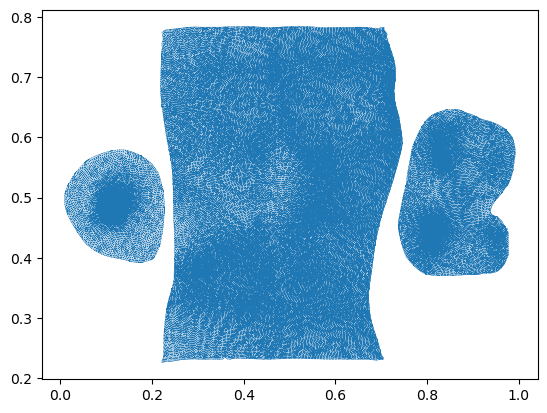

In [10]:
plt.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.texture_tris, lw=0.2)

## Trying to only subdivide long edges

In [9]:
mesh_cut = meshes_wrapped[-1].cut_along_seams()

In [10]:
mesh_cut.tris.shape, 40420/2

((40420, 3), 20210.0)

In [11]:
S, new_faces = igl.loop_subdivision_matrix(mesh_cut.vertices.shape[0], mesh_cut.tris[20210:])

In [12]:
new_textures = S.dot(mesh_cut.texture_vertices)

In [22]:
S.shape

(51570, 20623)

In [13]:
unique_faces = np.unique(np.vstack([mesh_cut.tris, new_faces]), axis=1)

In [14]:
new_verts = S.dot(mesh_cut.vertices)
mesh_subdiv_partial = tcmesh.ObjMesh(vertices=new_verts, texture_vertices=new_textures,
                                     faces=[[[v,v] for v in fc] for fc in unique_faces])


In [15]:
mesh_subdiv_partial.write_obj("movie_example/mesh_subdivided_partial_igl.obj")

In [106]:
new_faces.max()

51569

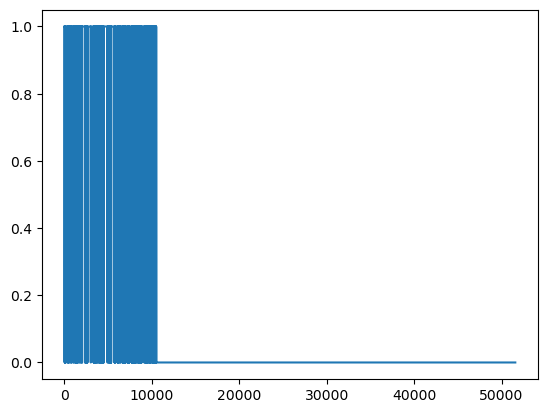

In [21]:
plt.plot(np.isnan(new_verts).any(axis=1))

### Improve mesh quality by using Delaunay

We can change our mesh topology while keeping vertex positions fixed by doing edge flips to avoid deformed triangles. This can be done using the intrinsic Delaunay algorithm. By cutting/regluing the mesh, we can avoid flipping edges along the seam, thus preserving UV information.

Note: this can lead to self-overlaps in the UV mapped triangulation. this can be fixed by a round of Laplacian smoothing of the UV coordinates.

In [4]:
#| export

def make_delaunay(mesh):
    """
    Make mesh triangles less deformed by edge flips. 
    
    This algorithm improves mesh quality (i.e. makes triangles less deformed)
    without moving vertices by "edge flips" using the Delaunay algorithm.
    UV information is preserved by forbidding the flip of edges along the
    UV seams.
    
    Note that this algorithm can lead to self-overlap of the UV map.
    You can fix this using wrapping.smooth_laplacian_texture.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.

    Returns
    -------
    mesh_new : ObjMesh
        Mesh with flipped edges.
    """
    if mesh.only_vertices:
        l = igl.edge_lengths(mesh.vertices, mesh.tris)
        l_new, f_new = igl.intrinsic_delaunay_triangulation(l, mesh.tris)
        mesh_new = tcmesh.ObjMesh(vertices=mesh.vertices, faces=f_new)
        return mesh_new
    mesh_cut = mesh.cut_along_seams()
    l = igl.edge_lengths(mesh_cut.vertices, mesh_cut.tris)
    l_new, f_new = igl.intrinsic_delaunay_triangulation(l, mesh_cut.tris)
    mesh_new = tcmesh.ObjMesh(vertices=mesh_cut.vertices, normals=mesh_cut.normals,
                              texture_vertices=mesh_cut.texture_vertices,
                              faces=[[[v,v] for v in fc] for fc in f_new])
    mesh_new = tcmesh.glue_seams(mesh_new, decimals=None)
    return mesh_new

In [5]:
mesh = tcmesh.ObjMesh.read_obj(f"movie_example/meshes_wrapped/mesh_20_wrapped.obj")

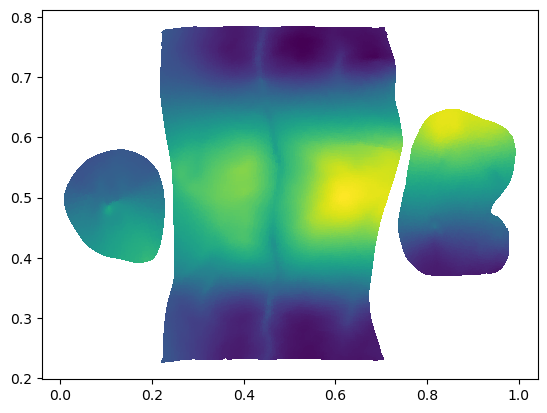

In [6]:
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, mesh.vertices[mesh.get_uv_matched_vertex_indices(),0])

In [7]:
mesh_new = make_delaunay(mesh)

In [8]:
mesh_new.write_obj(f"movie_example/mesh_20_wrapped_delaunay.obj")

### simplification/decimation with `igl`

Assigning texture coordinates simply based on the birth vertex is not great. can we do better? I guess not :\

In [30]:
#| export

def qslim(mesh, max_n_faces):
    """
    Simplify mesh by face decimation using qslim algorithm.
    
    Wrapper of igl.qslim. This _will_ destroy UV mapping information!
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    max_n_faces : int
        Maximum number of faces in output
    
    Returns
    -------
    mesh_new : ObjMesh
        Decimated mesh.

    """
    _, vertices_new, faces_new, _, _ = igl.qslim(mesh.vertices, mesh.tris, max_m=max_n_faces)
    return tcmesh.ObjMesh(vertices=vertices_new, faces=faces_new)

In [31]:
_, vertices_new, faces_new, birth_faces, birth_vertices = igl.qslim(mesh_subdiv.vertices, mesh_subdiv.tris,
                                                                    max_m=int(mesh_subdiv.tris.shape[0]/4))


In [28]:
vertices_new

array([[303.86093587, 196.36349537, 187.39330621],
       [295.04145435, 190.5967657 , 197.21598574],
       [298.07865413, 184.69474143, 205.48019216],
       ...,
       [463.84109485, 980.06529227, 542.6443938 ],
       [453.26863542, 989.7311289 , 552.81054468],
       [457.49207425, 993.12248454, 544.54433706]])

In [6]:
help(igl.qslim)    G  #G by 3 list of output face indices into U (can be same ref as G)
    J  #G list of indices into F of birth face

Help on built-in function qslim in module igl.pyigl:

qslim(...) method of builtins.PyCapsule instance
    qslim(v: numpy.ndarray, f: numpy.ndarray, max_m: int) -> Tuple[bool, object, object, object, object]
    
    
    
    Decimate (simplify) a triangle mesh in nD according to the paper
       "Simplifying Surfaces with Color and Texture using Quadric Error Metrics"
       by [Garland and Heckbert, 1987] (technically a followup to qslim). The
       mesh can have open boundaries but should be edge-manifold.
    
    Parameters
    ----------
    V  #V by dim list of vertex positions. Assumes that vertices w
    F  #F by 3 list of triangle indices into V
    max_m  desired number of output faces
    
    
    Returns
    -------
    U  #U by dim list of output vertex posistions (can be same ref as V)
    G  #G by 3 list of output face indices into U (can be same ref as G)
    J  #G list of indices into F of birth face
    I  #U list of indices into V of birth vertices
    
    
    

### simplification/decimation with `igl`

Assigning texture coordinates simply based on the birth vertex is not great - leads to poor UV maps. Can we do better? I guess not :\

In [25]:
mesh_simplified = tcmesh.ObjMesh(vertices=vertices_new,
                                 texture_vertices=mesh_subdiv.texture_vertices[birth_vertices],
                                 faces=[[[v,v] for v in fc] for fc in faces_new])

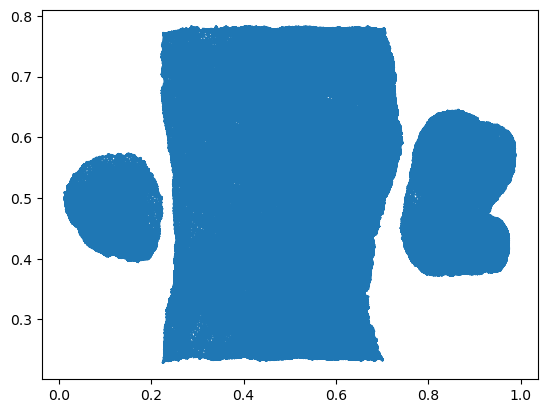

In [31]:
plt.triplot(*mesh_simplified.texture_vertices.T, mesh_simplified.tris)

In [32]:
mesh_simplified.write_obj("movie_example/mesh_subdivided_simplified_igl.obj")